# Patch-based LSTM Image Generation

Epoch 1/10
600/600 [==============================] - 155s 256ms/step - loss: 0.0914
Epoch 2/10
600/600 [==============================] - 155s 258ms/step - loss: 0.0586
Epoch 3/10
600/600 [==============================] - 154s 257ms/step - loss: 0.0505
Epoch 4/10
600/600 [==============================] - 151s 252ms/step - loss: 0.0460
Epoch 5/10
600/600 [==============================] - 175s 291ms/step - loss: 0.0432
Epoch 6/10
600/600 [==============================] - 190s 316ms/step - loss: 0.0413
Epoch 7/10
600/600 [==============================] - 201s 335ms/step - loss: 0.0399
Epoch 8/10
600/600 [==============================] - 202s 337ms/step - loss: 0.0388
Epoch 9/10
600/600 [==============================] - 206s 342ms/step - loss: 0.0379
Epoch 10/10
1/1 [==============================] - 0s 29ms/step
Epoch 1/10
500/500 [==============================] - 153s 306ms/step - loss: 0.0366 - val_loss: 0.0360
Epoch 2/10
500/500 [==============================] - 150s 301ms/st

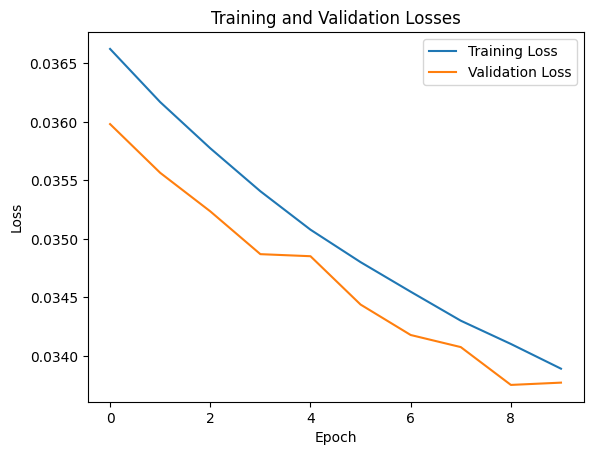

Test Loss: 0.03387715667486191


In [227]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# vectorize the images into patches
def create_patches(x, patch_size=7):
    patches = np.array([x[i:i+patch_size, j:j+patch_size] for i in range(0,28,patch_size) for j in range(0,28,patch_size)])
    return patches.reshape(-1, patch_size*patch_size)

# training sequences
x_train_patches = np.array([create_patches(x) for x in x_train])
x_test_patches = np.array([create_patches(x) for x in x_test])

# Reshape and normalize
x_train_patches = x_train_patches.reshape(-1, 16, 49) / 255.0
x_test_patches = x_test_patches.reshape(-1, 16, 49) / 255.0

# Shift the patches
x_train_rnn = x_train_patches[:, :-1]
y_train_rnn = x_train_patches[:, 1:]

# LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(None, 49), return_sequences=True))
model.add(TimeDistributed(Dense(49, activation='sigmoid')))

# compile / train
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train_rnn, y_train_rnn, batch_size=100, epochs=10)

# predict the next patch
def predict_next_patch(model, sequence):
    prediction = model.predict(sequence)
    return prediction[:, -1, :]

# Predict the entire lower half
def predict_lower_half(model, upper_half_patches):
    current_sequence = np.array([upper_half_patches])
    for _ in range(8):  # We have to predict the next 8 patches
        next_patch = predict_next_patch(model, current_sequence)
        current_sequence = np.concatenate((current_sequence, next_patch[:, None, :]), axis=1)
    return current_sequence[0, 8:]

# function to generate the lower half of the digits
generated_patches = predict_lower_half(model, x_test_patches[0, :8])


# last 10000 validation set
x_val_rnn = x_train_patches[-10000:, :-1]
y_val_rnn = x_train_patches[-10000:, 1:]
x_train_rnn = x_train_patches[:-10000, :-1]
y_train_rnn = x_train_patches[:-10000, 1:]

# early stopping 
early_stopping = EarlyStopping(monitor='val_loss', patience=3)


history = model.fit(x_train_rnn, y_train_rnn, validation_data=(x_val_rnn, y_val_rnn), 
                    batch_size=100, epochs=10, callbacks=[early_stopping])

# Plot 
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate the test set
x_test_rnn = x_test_patches[:, :-1]
y_test_rnn = x_test_patches[:, 1:]
test_loss = model.evaluate(x_test_rnn, y_test_rnn, verbose=0)
print(f'Test Loss: {test_loss}')

313/313 [==============================] - 10s 30ms/step


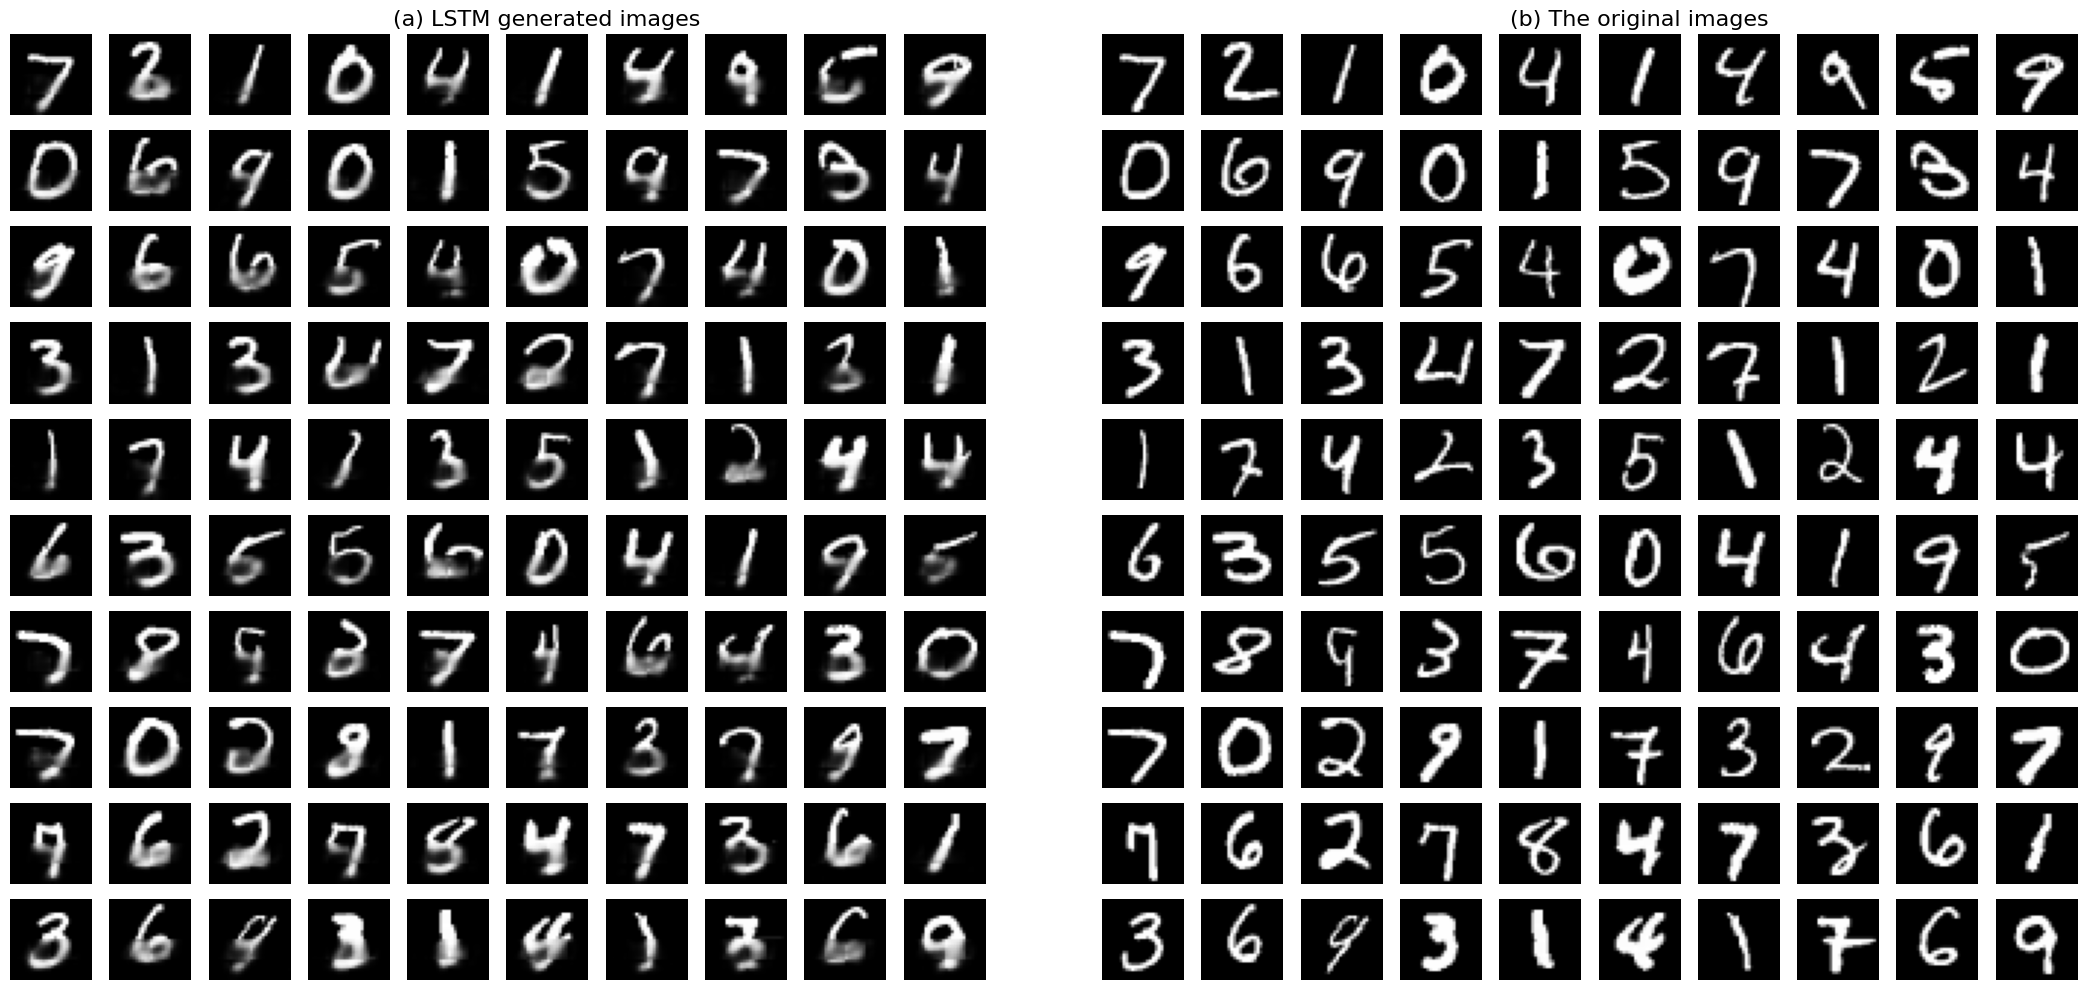

In [229]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed

def generate_full_image(model, initial_patches):
    new_patches = initial_patches
    for i in range(8, 16):  # generate second half images
        next_patch = model.predict(new_patches[:, :i, :])
        new_patches = np.concatenate([new_patches, next_patch[:, -1:, :]], axis=1)
    return new_patches

# patch to images
def patches_to_images(patches, patch_size=7):
    num_images = patches.shape[0]
    new_images = np.zeros((num_images, 28, 28))
    
    for img_idx in range(num_images):
        for patch_idx in range(16):
            i = patch_idx // 4
            j = patch_idx % 4
            patch = patches[img_idx, patch_idx].reshape(patch_size, patch_size)
            new_images[img_idx, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = patch
            
    return new_images

# create full images
initial_patches = x_test_patches[:, :8, :]  
generated_patches = generate_full_image(model, initial_patches)  
generated_images = patches_to_images(generated_patches) 


num_images_per_row = 10
num_rows = 10

fig, axs = plt.subplots(num_rows, num_images_per_row * 2 + 1, figsize=(21, 10)) 

for i in range(num_rows):  
    for j in range(num_images_per_row):  
        index = i * num_images_per_row + j
        axs[i, j].imshow(generated_images[index], cmap='gray')
        axs[i, j].axis('off')

    axs[i, num_images_per_row].axis('off')  

    for j in range(num_images_per_row + 1, num_images_per_row * 2 + 1): 
        index = i * num_images_per_row + (j - (num_images_per_row + 1))
        axs[i, j].imshow(x_test[index].reshape(28, 28), cmap='gray')
        axs[i, j].axis('off')

axs[0, num_images_per_row // 2].set_title('(a) LSTM generated images', fontsize=16)
axs[0, num_images_per_row + (num_images_per_row // 2) + 1].set_title('(b) The original images', fontsize=16)

plt.tight_layout()
plt.show()


# Variational AutoEncoder (VAE)

##### I spent a lot of time trying out various codes for this problem. I tried to perfectly implement the contents of the homework instructions. However, despite many attempts, I feel like the resulting image was created differently than I expected. I've tried so many times that these images haunt me even when I sleep. But I tried and tried a lot and was able to learn a lot in the process.

In [213]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pickle

def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

x_train = load_data('tr7.pkl').reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = load_data('te7.pkl').reshape(-1, 28, 28, 1).astype('float32') / 255.

# cnn with dense
class Encoder(layers.Layer):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')
        self.conv2 = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')
        self.flatten = layers.Flatten()
        self.fc = layers.Dense(16) 
        self.fc_mu = layers.Dense(latent_dim)
        self.fc_logvar = layers.Dense(latent_dim)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc(x)  
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(layers.Layer):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.dense = layers.Dense(64 * 7 * 7, activation='relu')
        self.reshape = layers.Reshape((7, 7, 64))
        self.convT1 = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')
        self.convT2 = layers.Conv2DTranspose(1, 3, strides=2, padding='same', activation='sigmoid')

    def call(self, z):
        z = self.dense(z)  
        z = self.reshape(z)
        z = self.convT1(z)
        return self.convT2(z)


In [216]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss
        }

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = sampling(z_mean, z_log_var)  # generate z
        reconstructed = self.decoder(z)
        return reconstructed

latent_dim = 5
encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)
vae = VAE(encoder, decoder)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae.compile(optimizer=optimizer)

epochs = 100
batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size)

def sampling(z_mean, z_log_var):
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

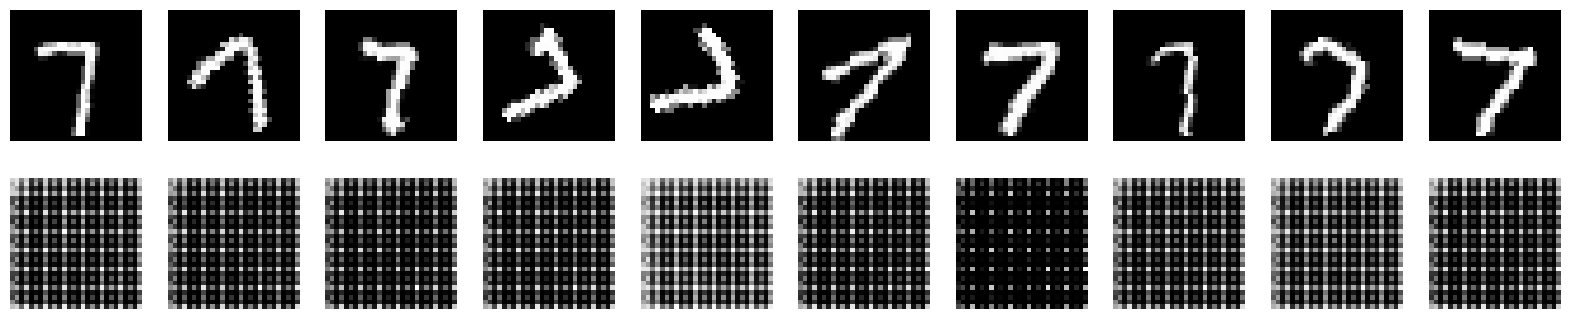

Epoch 1/100, Loss: 182.8035125732422


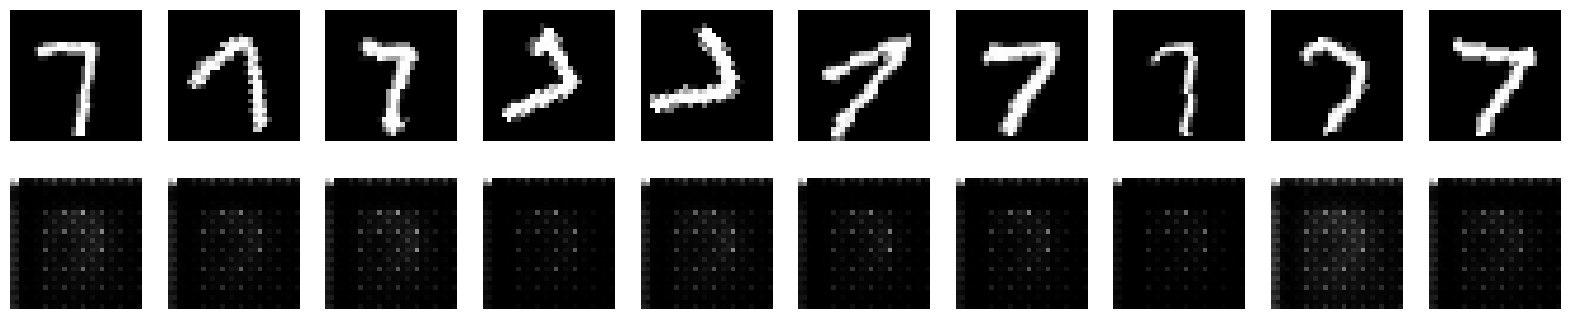

Epoch 11/100, Loss: 4.826684474945068


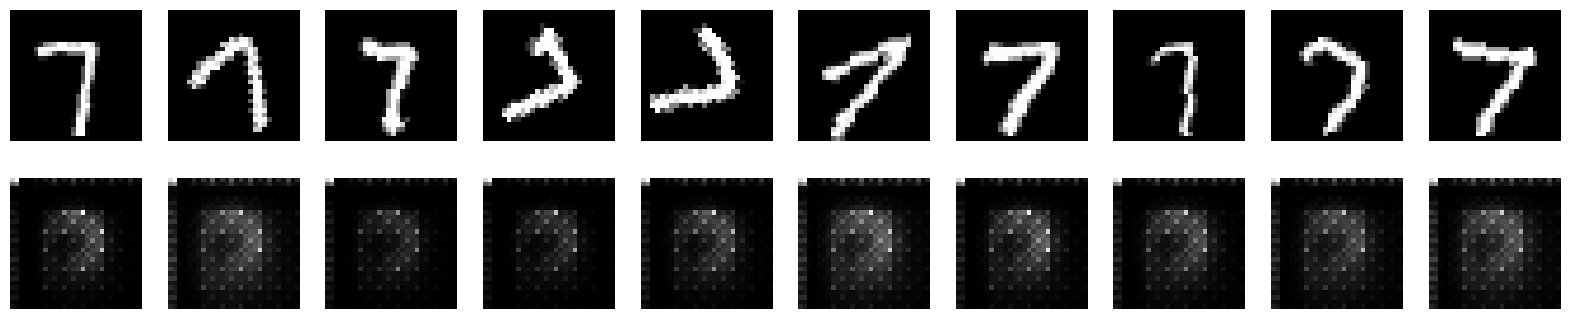

Epoch 21/100, Loss: 3.9740047454833984


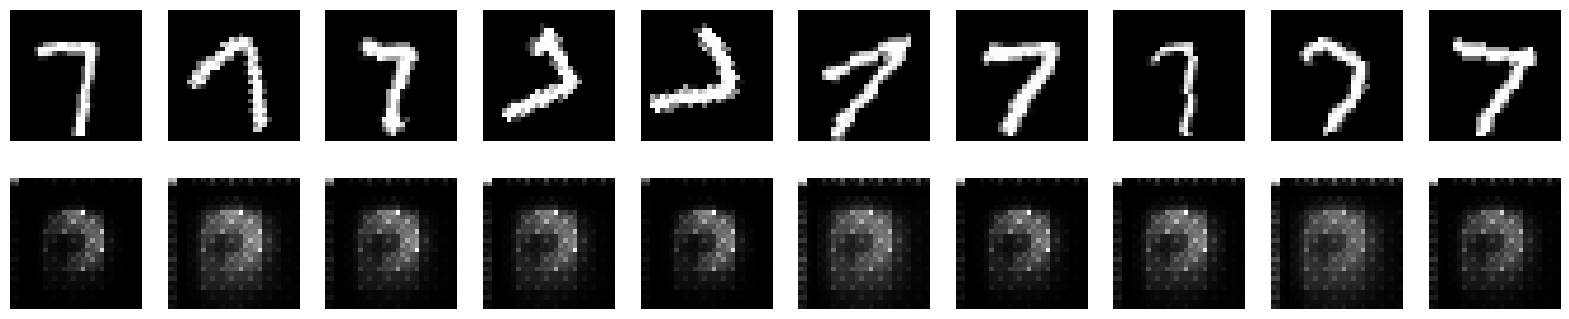

Epoch 31/100, Loss: 3.7394206523895264


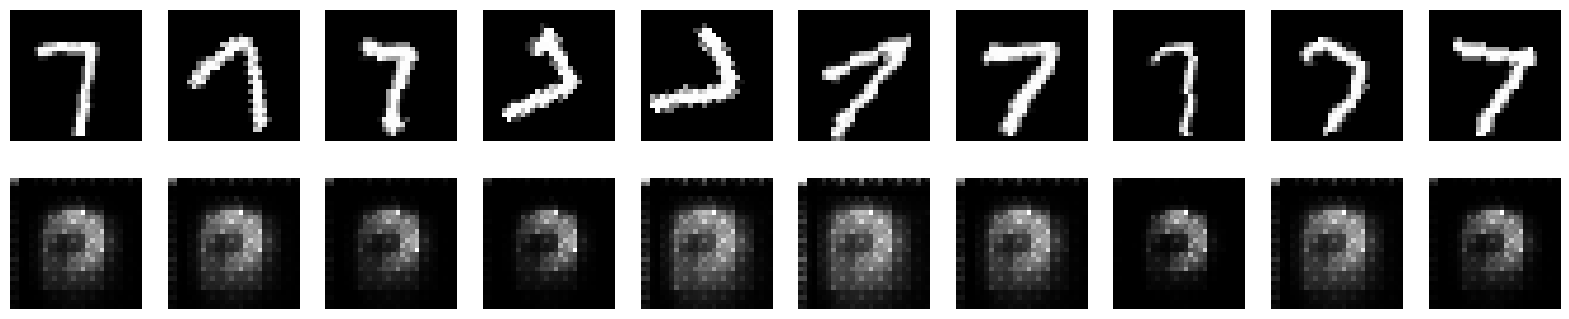

Epoch 41/100, Loss: 3.698824882507324


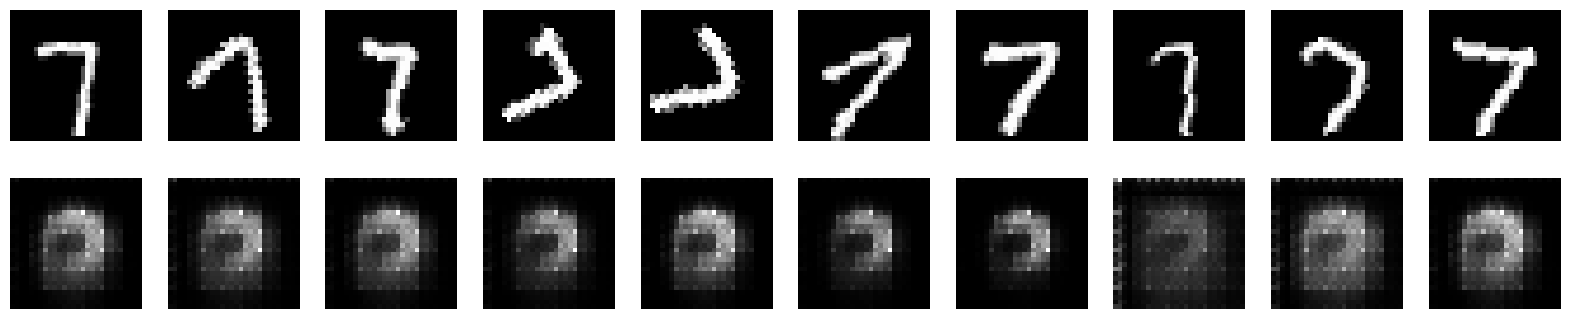

Epoch 51/100, Loss: 3.413076400756836


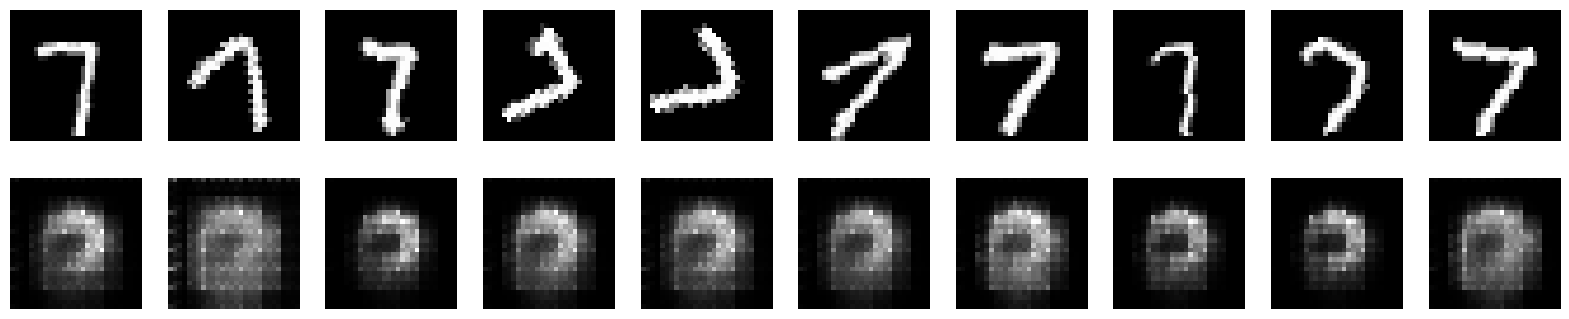

Epoch 61/100, Loss: 3.2099502086639404


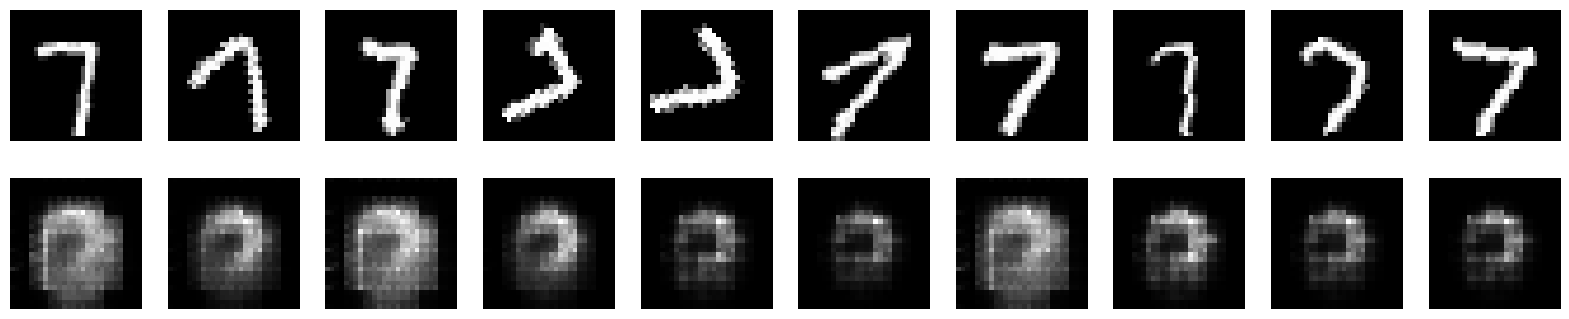

Epoch 71/100, Loss: 3.065323829650879


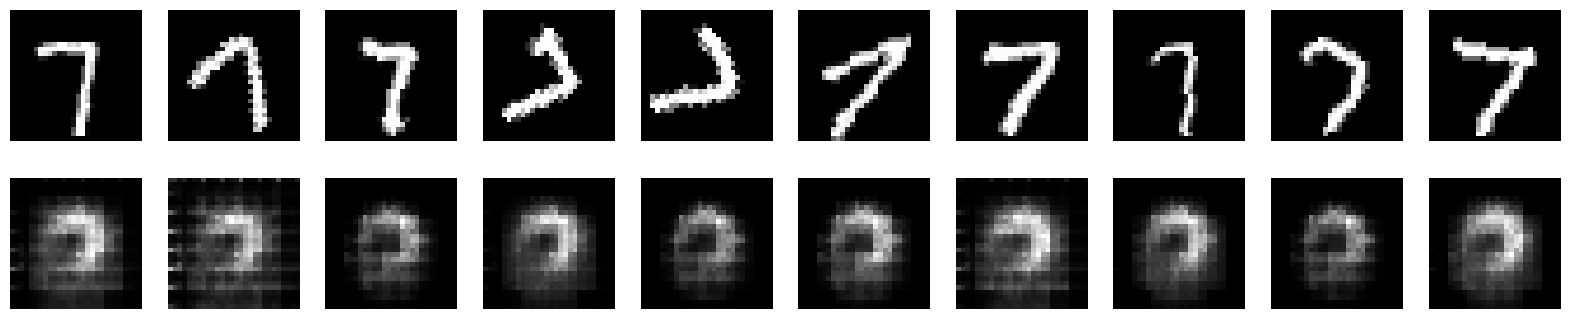

Epoch 81/100, Loss: 2.942838668823242


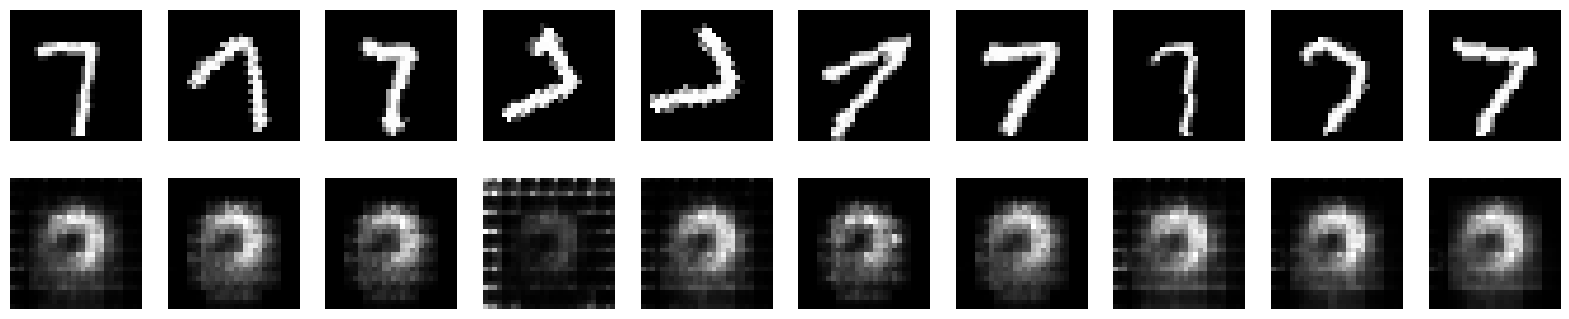

Epoch 91/100, Loss: 2.7993223667144775


In [217]:
# Train and viz
for epoch in range(epochs):
    for x_batch_train in train_dataset:
        with tf.GradientTape() as tape:
            z_mean, z_log_var = vae.encoder(x_batch_train)
            z = sampling(z_mean, z_log_var)
            reconstruction = vae.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(x_batch_train, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    # Viz every 10 epochs
    if epoch % 10 == 0:
        test_sample = x_train[:10]  #
        reconstructions = vae(test_sample).numpy()  
        reconstructions = np.squeeze(reconstructions, axis=-1) 

        plt.figure(figsize=(20, 4))
        for i in range(10):
            # Original
            plt.subplot(2, 10, i + 1)
            plt.imshow(test_sample[i].squeeze(), cmap='gray')
            plt.axis('off')

            # Reconstructed
            plt.subplot(2, 10, i + 11)
            plt.imshow(reconstructions[i], cmap='gray')
            plt.axis('off')
        plt.show()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss.numpy()}')

Latent Dimension 1 Samples:
[[ 1.01210277 -0.73052342  1.5779396  -1.24424527 -0.48339144]
 [-0.57204155 -0.73052342  1.5779396  -1.24424527 -0.48339144]
 [ 2.2769374  -0.73052342  1.5779396  -1.24424527 -0.48339144]
 [-1.44036658 -0.73052342  1.5779396  -1.24424527 -0.48339144]
 [-0.13942285 -0.73052342  1.5779396  -1.24424527 -0.48339144]
 [-1.15608426 -0.73052342  1.5779396  -1.24424527 -0.48339144]
 [-0.66324564 -0.73052342  1.5779396  -1.24424527 -0.48339144]
 [ 0.40524075 -0.73052342  1.5779396  -1.24424527 -0.48339144]
 [ 0.78340181 -0.73052342  1.5779396  -1.24424527 -0.48339144]
 [ 0.46429849 -0.73052342  1.5779396  -1.24424527 -0.48339144]]


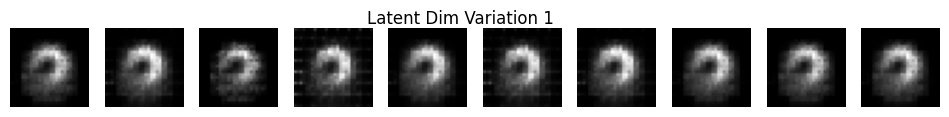

Latent Dimension 2 Samples:
[[-0.41628745 -0.52682124  1.32522946  0.42239877 -1.00561932]
 [-0.41628745  0.82978491  1.32522946  0.42239877 -1.00561932]
 [-0.41628745  0.16234282  1.32522946  0.42239877 -1.00561932]
 [-0.41628745  1.54628772  1.32522946  0.42239877 -1.00561932]
 [-0.41628745  1.66968512  1.32522946  0.42239877 -1.00561932]
 [-0.41628745  0.13542118  1.32522946  0.42239877 -1.00561932]
 [-0.41628745  0.91799282  1.32522946  0.42239877 -1.00561932]
 [-0.41628745  0.61425505  1.32522946  0.42239877 -1.00561932]
 [-0.41628745 -1.55989914  1.32522946  0.42239877 -1.00561932]
 [-0.41628745 -0.68896239  1.32522946  0.42239877 -1.00561932]]


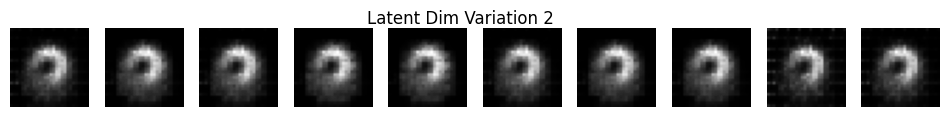

Latent Dimension 3 Samples:
[[-0.30297679  0.94126005  1.93957114  0.2317759  -0.3049258 ]
 [-0.30297679  0.94126005  0.11125013  0.2317759  -0.3049258 ]
 [-0.30297679  0.94126005 -0.44086015  0.2317759  -0.3049258 ]
 [-0.30297679  0.94126005 -0.47645847  0.2317759  -0.3049258 ]
 [-0.30297679  0.94126005 -0.44665775  0.2317759  -0.3049258 ]
 [-0.30297679  0.94126005 -1.19318002  0.2317759  -0.3049258 ]
 [-0.30297679  0.94126005 -0.90837826  0.2317759  -0.3049258 ]
 [-0.30297679  0.94126005  0.36170445  0.2317759  -0.3049258 ]
 [-0.30297679  0.94126005 -1.81209769  0.2317759  -0.3049258 ]
 [-0.30297679  0.94126005  1.21845298  0.2317759  -0.3049258 ]]


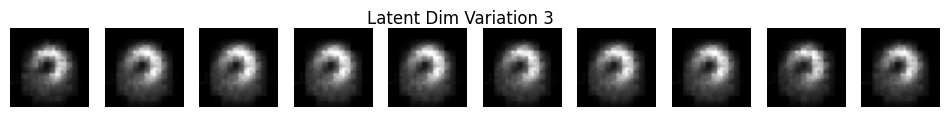

Latent Dimension 4 Samples:
[[-0.85768333 -1.5555685  -0.44895606 -0.23787458  0.35050065]
 [-0.85768333 -1.5555685  -0.44895606  1.06487281  0.35050065]
 [-0.85768333 -1.5555685  -0.44895606 -0.03228518  0.35050065]
 [-0.85768333 -1.5555685  -0.44895606 -0.69433159  0.35050065]
 [-0.85768333 -1.5555685  -0.44895606  0.77956552  0.35050065]
 [-0.85768333 -1.5555685  -0.44895606 -2.28904287  0.35050065]
 [-0.85768333 -1.5555685  -0.44895606 -1.13334542  0.35050065]
 [-0.85768333 -1.5555685  -0.44895606 -0.82382953  0.35050065]
 [-0.85768333 -1.5555685  -0.44895606 -1.20087987  0.35050065]
 [-0.85768333 -1.5555685  -0.44895606  0.3738097   0.35050065]]


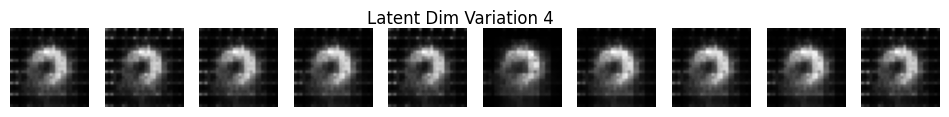

Latent Dimension 5 Samples:
[[-0.02640787  0.17912855  0.77366359  1.20029354  1.41782339]
 [-0.02640787  0.17912855  0.77366359  1.20029354  1.0037609 ]
 [-0.02640787  0.17912855  0.77366359  1.20029354  0.07635541]
 [-0.02640787  0.17912855  0.77366359  1.20029354  0.44348983]
 [-0.02640787  0.17912855  0.77366359  1.20029354  1.28268178]
 [-0.02640787  0.17912855  0.77366359  1.20029354  0.81731478]
 [-0.02640787  0.17912855  0.77366359  1.20029354  0.9893803 ]
 [-0.02640787  0.17912855  0.77366359  1.20029354  1.84974955]
 [-0.02640787  0.17912855  0.77366359  1.20029354  0.25750978]
 [-0.02640787  0.17912855  0.77366359  1.20029354  0.40326651]]


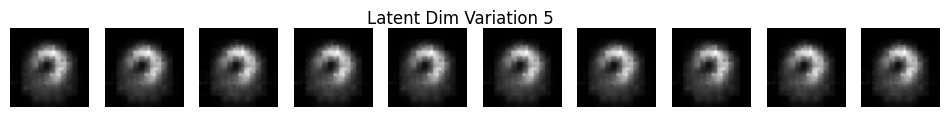

In [224]:
# Dimension variation 

def plot_fixed_latent_dimensions_tf(vae, latent_dim, num_samples=10, figsize=(12, 1.2)):
    for dim in range(latent_dim):
        fixed_value = np.random.normal(size=(1, latent_dim))
        variable_values = np.random.normal(size=(num_samples, 1))
        z_samples = np.tile(fixed_value, (num_samples, 1))
        z_samples[:, dim] = variable_values[:, 0]

        print(f"Latent Dimension {dim + 1} Samples:")
        print(z_samples)

        generated_images = []
        for z_sample in z_samples:
            x_decoded = vae.decoder(tf.convert_to_tensor([z_sample], dtype=tf.float32))
            generated_images.append(x_decoded[0].numpy().reshape(28, 28))

        plt.figure(figsize=figsize)
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(generated_images[i], cmap='gray')
            plt.axis('off')
        plt.suptitle(f'Latent Dim Variation {dim + 1}')
        plt.show()

latent_dim = 5
plot_fixed_latent_dimensions_tf(vae, latent_dim)

Latent Dimension 1 Samples:
[[-3.0000000e+00 -1.6379580e-03 -1.5403396e-03 -1.4262730e-02
   1.5689559e-02]
 [-2.3333333e+00 -1.6379580e-03 -1.5403396e-03 -1.4262730e-02
   1.5689559e-02]
 [-1.6666666e+00 -1.6379580e-03 -1.5403396e-03 -1.4262730e-02
   1.5689559e-02]
 [-1.0000000e+00 -1.6379580e-03 -1.5403396e-03 -1.4262730e-02
   1.5689559e-02]
 [-3.3333334e-01 -1.6379580e-03 -1.5403396e-03 -1.4262730e-02
   1.5689559e-02]
 [ 3.3333334e-01 -1.6379580e-03 -1.5403396e-03 -1.4262730e-02
   1.5689559e-02]
 [ 1.0000000e+00 -1.6379580e-03 -1.5403396e-03 -1.4262730e-02
   1.5689559e-02]
 [ 1.6666666e+00 -1.6379580e-03 -1.5403396e-03 -1.4262730e-02
   1.5689559e-02]
 [ 2.3333333e+00 -1.6379580e-03 -1.5403396e-03 -1.4262730e-02
   1.5689559e-02]
 [ 3.0000000e+00 -1.6379580e-03 -1.5403396e-03 -1.4262730e-02
   1.5689559e-02]]


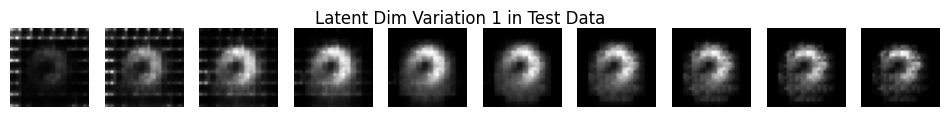

Latent Dimension 2 Samples:
[[ 3.0584224e-02 -3.0000000e+00 -1.5403396e-03 -1.4262730e-02
   1.5689559e-02]
 [ 3.0584224e-02 -2.3333333e+00 -1.5403396e-03 -1.4262730e-02
   1.5689559e-02]
 [ 3.0584224e-02 -1.6666666e+00 -1.5403396e-03 -1.4262730e-02
   1.5689559e-02]
 [ 3.0584224e-02 -1.0000000e+00 -1.5403396e-03 -1.4262730e-02
   1.5689559e-02]
 [ 3.0584224e-02 -3.3333334e-01 -1.5403396e-03 -1.4262730e-02
   1.5689559e-02]
 [ 3.0584224e-02  3.3333334e-01 -1.5403396e-03 -1.4262730e-02
   1.5689559e-02]
 [ 3.0584224e-02  1.0000000e+00 -1.5403396e-03 -1.4262730e-02
   1.5689559e-02]
 [ 3.0584224e-02  1.6666666e+00 -1.5403396e-03 -1.4262730e-02
   1.5689559e-02]
 [ 3.0584224e-02  2.3333333e+00 -1.5403396e-03 -1.4262730e-02
   1.5689559e-02]
 [ 3.0584224e-02  3.0000000e+00 -1.5403396e-03 -1.4262730e-02
   1.5689559e-02]]


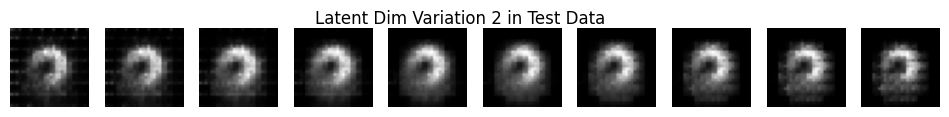

Latent Dimension 3 Samples:
[[ 3.0584224e-02 -1.6379580e-03 -3.0000000e+00 -1.4262730e-02
   1.5689559e-02]
 [ 3.0584224e-02 -1.6379580e-03 -2.3333333e+00 -1.4262730e-02
   1.5689559e-02]
 [ 3.0584224e-02 -1.6379580e-03 -1.6666666e+00 -1.4262730e-02
   1.5689559e-02]
 [ 3.0584224e-02 -1.6379580e-03 -1.0000000e+00 -1.4262730e-02
   1.5689559e-02]
 [ 3.0584224e-02 -1.6379580e-03 -3.3333334e-01 -1.4262730e-02
   1.5689559e-02]
 [ 3.0584224e-02 -1.6379580e-03  3.3333334e-01 -1.4262730e-02
   1.5689559e-02]
 [ 3.0584224e-02 -1.6379580e-03  1.0000000e+00 -1.4262730e-02
   1.5689559e-02]
 [ 3.0584224e-02 -1.6379580e-03  1.6666666e+00 -1.4262730e-02
   1.5689559e-02]
 [ 3.0584224e-02 -1.6379580e-03  2.3333333e+00 -1.4262730e-02
   1.5689559e-02]
 [ 3.0584224e-02 -1.6379580e-03  3.0000000e+00 -1.4262730e-02
   1.5689559e-02]]


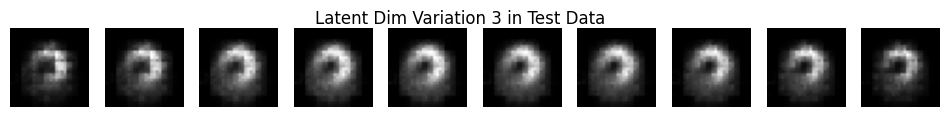

Latent Dimension 4 Samples:
[[ 3.0584224e-02 -1.6379580e-03 -1.5403396e-03 -3.0000000e+00
   1.5689559e-02]
 [ 3.0584224e-02 -1.6379580e-03 -1.5403396e-03 -2.3333333e+00
   1.5689559e-02]
 [ 3.0584224e-02 -1.6379580e-03 -1.5403396e-03 -1.6666666e+00
   1.5689559e-02]
 [ 3.0584224e-02 -1.6379580e-03 -1.5403396e-03 -1.0000000e+00
   1.5689559e-02]
 [ 3.0584224e-02 -1.6379580e-03 -1.5403396e-03 -3.3333334e-01
   1.5689559e-02]
 [ 3.0584224e-02 -1.6379580e-03 -1.5403396e-03  3.3333334e-01
   1.5689559e-02]
 [ 3.0584224e-02 -1.6379580e-03 -1.5403396e-03  1.0000000e+00
   1.5689559e-02]
 [ 3.0584224e-02 -1.6379580e-03 -1.5403396e-03  1.6666666e+00
   1.5689559e-02]
 [ 3.0584224e-02 -1.6379580e-03 -1.5403396e-03  2.3333333e+00
   1.5689559e-02]
 [ 3.0584224e-02 -1.6379580e-03 -1.5403396e-03  3.0000000e+00
   1.5689559e-02]]


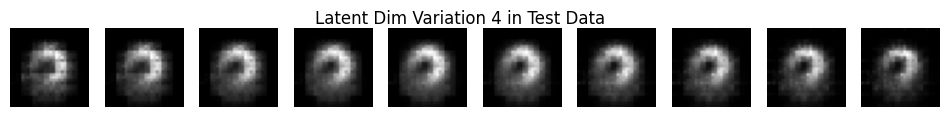

Latent Dimension 5 Samples:
[[ 3.0584224e-02 -1.6379580e-03 -1.5403396e-03 -1.4262730e-02
  -3.0000000e+00]
 [ 3.0584224e-02 -1.6379580e-03 -1.5403396e-03 -1.4262730e-02
  -2.3333333e+00]
 [ 3.0584224e-02 -1.6379580e-03 -1.5403396e-03 -1.4262730e-02
  -1.6666666e+00]
 [ 3.0584224e-02 -1.6379580e-03 -1.5403396e-03 -1.4262730e-02
  -1.0000000e+00]
 [ 3.0584224e-02 -1.6379580e-03 -1.5403396e-03 -1.4262730e-02
  -3.3333334e-01]
 [ 3.0584224e-02 -1.6379580e-03 -1.5403396e-03 -1.4262730e-02
   3.3333334e-01]
 [ 3.0584224e-02 -1.6379580e-03 -1.5403396e-03 -1.4262730e-02
   1.0000000e+00]
 [ 3.0584224e-02 -1.6379580e-03 -1.5403396e-03 -1.4262730e-02
   1.6666666e+00]
 [ 3.0584224e-02 -1.6379580e-03 -1.5403396e-03 -1.4262730e-02
   2.3333333e+00]
 [ 3.0584224e-02 -1.6379580e-03 -1.5403396e-03 -1.4262730e-02
   3.0000000e+00]]


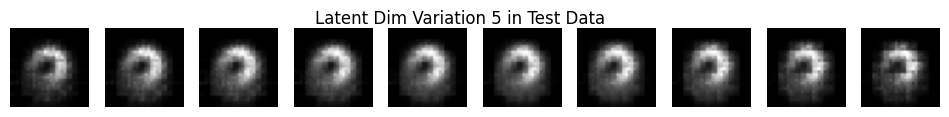

In [225]:
# Dimension variation with TEST DATASET!!

def visualize_latent_space_with_test_data(vae, x_test, latent_dim=5, num_samples=10, figsize=(12, 1.2)):

    z_mean, z_log_var = vae.encoder(x_test[:1])
    z_mean = z_mean.numpy()

    for dim in range(latent_dim):
        fixed_value = np.copy(z_mean)
        z_variation = np.linspace(-3, 3, num_samples)
        z_samples = np.repeat(fixed_value, num_samples, axis=0)
        z_samples[:, dim] = z_variation

        print(f"Latent Dimension {dim + 1} Samples:")
        print(z_samples)

        generated_images = vae.decoder(tf.convert_to_tensor(z_samples, dtype=tf.float32))
        generated_images = generated_images.numpy().reshape(-1, 28, 28)

        plt.figure(figsize=figsize)
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(generated_images[i], cmap='gray')
            plt.axis('off')
        plt.suptitle(f'Latent Dim Variation {dim + 1} in Test Data')
        plt.show()

visualize_latent_space_with_test_data(vae, x_test, latent_dim=5, num_samples=10)



# Conditional GAN (cGAN)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
8/8 [==============================] - 0s 32ms/step - loss: 0.6364 - accuracy: 0.9531


8/8 [==============================] - 0s 14ms/step


8/8 [==============================] - 0s 28ms/step - loss: 0.4669 - accuracy: 0.7070


8/8 [==============================] - 0s 12ms/step


8/8 [==============================] - 0s 29ms/step - loss: 0.3945 - accuracy: 0.7773


8/8 [==============================] - 0s 11ms/step


8/8 [==============================] - 0s 29ms/step - loss: 0.4560 - accuracy: 0.6797


8/8 [==============================] - 0s 14ms/step


8/8 [==============================] - 0s 33ms/step - loss: 0.6361 - accuracy: 0.4805


8/8 [==============================] - 0s 12ms/step


8/8 [==============================] - 0s 33ms/step - loss: 0.6878 - accuracy: 0.4180


8/8 [==============================] - 0s 20ms/step


8/8 [==============================] - 0s 32ms/step - loss: 0.6749 - accuracy: 0.3164


8/8 [==============================] - 0s 16ms/step


8/8 [==============================] - 0s 34ms/step - loss: 0.6561 - accuracy: 0.4102


8/8 [==============================] - 0s 31ms/step - loss: 0.6119 - accuracy: 0.9141


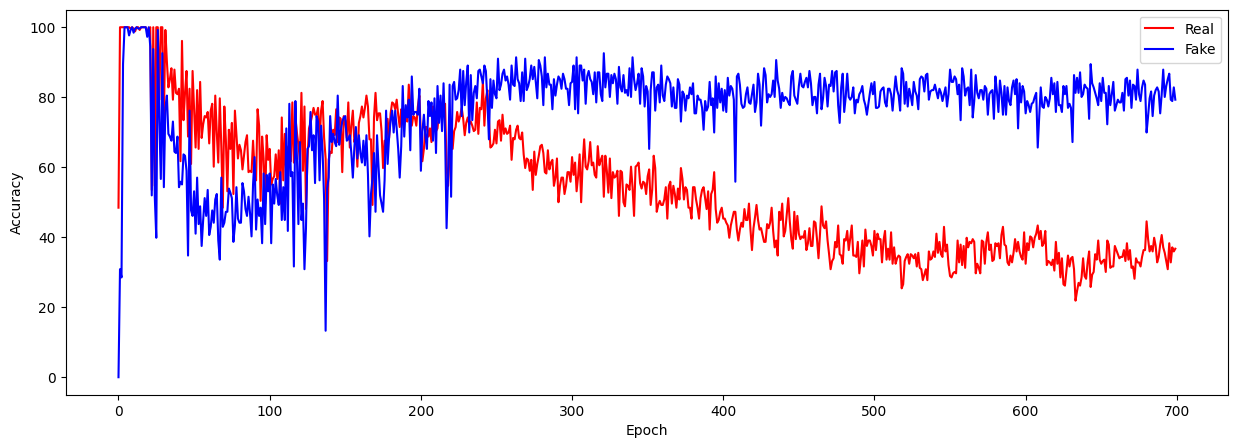

4/4 [==============================] - 0s 13ms/step


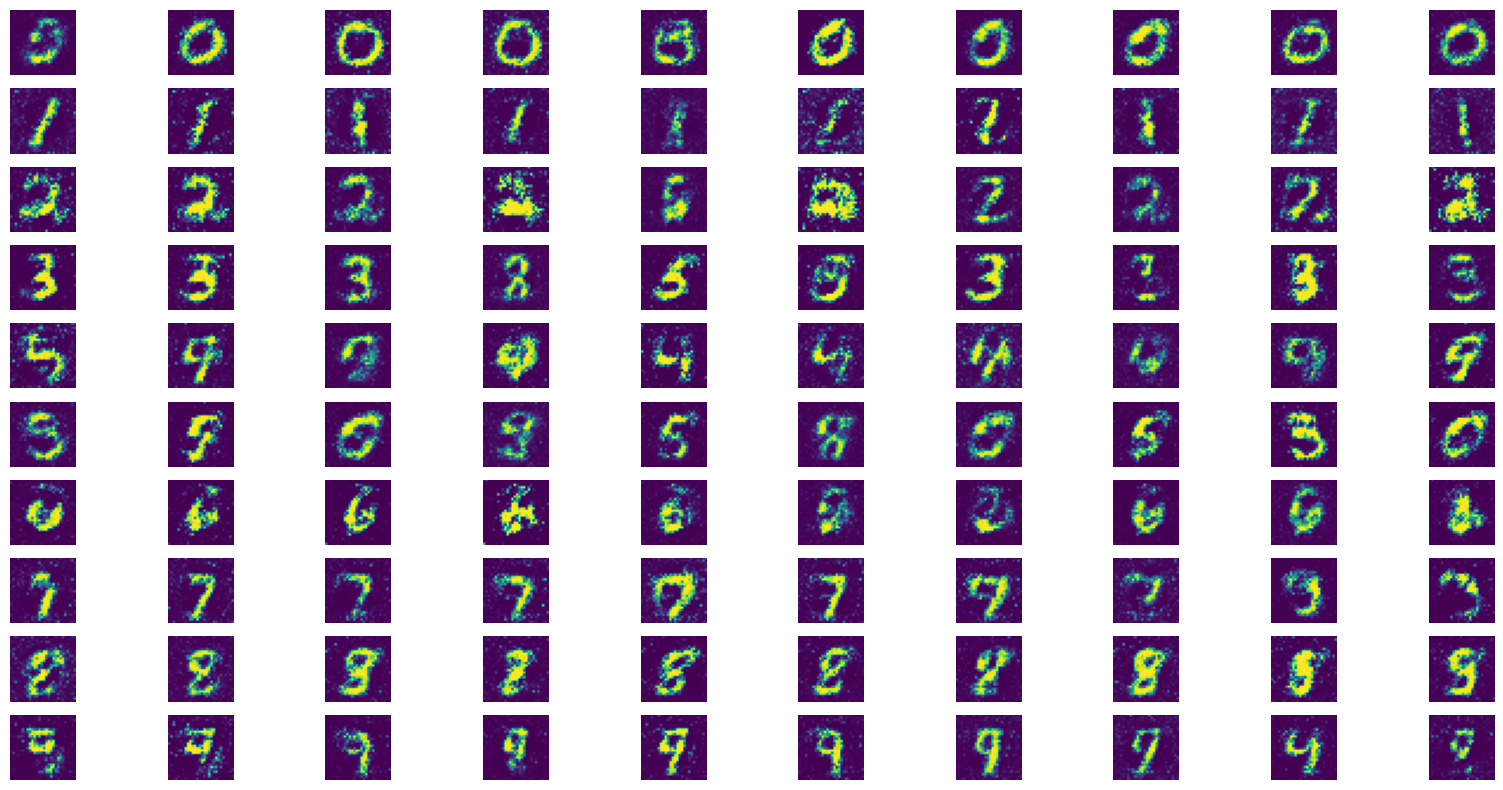

In [196]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Embedding, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# MNIST Classes
num_classes = 10

# Checking One-Hot Ecoding Function
def check_one_hot_encoding(labels, num_classes):
    one_hot_encoded = tf.keras.utils.to_categorical(labels, num_classes)
    print(one_hot_encoded[:10])  # Check 10 


# Data load
def load_mnist_data():
    (x_train, y_train), (_, _) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5 
    x_train = np.expand_dims(x_train, axis=3)  # add D 
    y_train = y_train.reshape(-1, 1)
    return x_train, y_train

X_train, y_train = load_mnist_data()

# Checking One-Hot Ecoding
check_one_hot_encoding(y_train[:10], num_classes)


def build_generator(z_dim, num_classes):
    z = Input(shape=(z_dim,))
    labels = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, z_dim)(labels))
    joined_representation = Concatenate()([z, label_embedding])

    x = Dense(128, activation='relu')(joined_representation)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(np.prod(img_shape), activation='tanh')(x)
    img = Reshape(img_shape)(x)

    model = Model([z, labels], img)
    return model

def build_discriminator(img_shape, num_classes):
    img = Input(shape=img_shape)
    labels = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(labels))
    flat_img = Flatten()(img)

    joined_representation = Concatenate()([flat_img, label_embedding])

    x = Dense(512, activation='relu')(joined_representation)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    validity = Dense(1, activation='sigmoid')(x)

    model = Model([img, labels], validity)
    return model

def build_cgan(generator, discriminator):
    z = Input(shape=(z_dim,))
    labels = Input(shape=(1,))
    img = generator([z, labels])
    discriminator.trainable = False
    validity = discriminator([img, labels])
    cgan = Model([z, labels], validity)
    return cgan

# Parmeters
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
num_classes = 10
z_dim = 100

# initantiate generator / discriminator
generator = build_generator(z_dim, num_classes)
discriminator = build_discriminator(img_shape, num_classes)

# D compile
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(0.002,0.5),
                      metrics=['accuracy'])

# CGAN compile
cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam(0.002,0.5))

batch_size = 256
epochs = 700
sample_interval = 1

real_acc_history = []
fake_acc_history = []

# test data load
(_, _), (x_test, y_test) = mnist.load_data()
x_test = (x_test.astype(np.float32) - 127.5) / 127.5
x_test = np.expand_dims(x_test, axis=3)
y_test = y_test.reshape(-1, 1)

# real and fake slot
test_acc_real = []
test_acc_fake = []


for epoch in range(epochs):
    # generate real image batch
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_imgs, labels = X_train[idx], y_train[idx]

    # generate fake image batch
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    fake_imgs = generator.predict([noise, labels])

    # train discriminator
    d_loss_real = discriminator.train_on_batch([real_imgs, labels], np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch([fake_imgs, labels], np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # train cgan 
    g_loss = cgan.train_on_batch([noise, labels], np.ones((batch_size, 1)))

    # accuracy
    real_acc_history.append(100 * d_loss_real[1])
    fake_acc_history.append(100 * d_loss_fake[1])

    # evaluation 
    if epoch % sample_interval == 0:
        idx = np.random.randint(0, x_test.shape[0], batch_size)
        test_imgs, test_labels = x_test[idx], y_test[idx]

        noise = np.random.normal(0, 1, (batch_size, z_dim))
        fake_imgs = generator.predict([noise, test_labels])

        d_loss_real = discriminator.evaluate([test_imgs, test_labels], np.ones((batch_size, 1)))
        d_loss_fake = discriminator.evaluate([fake_imgs, test_labels], np.zeros((batch_size, 1)))

        test_acc_real.append(100 * d_loss_real[1])
        test_acc_fake.append(100 * d_loss_fake[1])
 

def plot_accuracy(real_acc_history, fake_acc_history, epochs):
    plt.figure(figsize=(15, 5))
    plt.plot(range(epochs), real_acc_history, label='Real', color='red')
    plt.plot(range(epochs), fake_acc_history, label='Fake', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
        
        
def sample_colored_images(generator, num_classes=10, samples_per_class=10):
    noise = np.random.normal(0, 1, (num_classes * samples_per_class, z_dim))
    sampled_labels = np.array([[i] * samples_per_class for i in range(num_classes)]).reshape(-1, 1)

    generated_images = generator.predict([noise, sampled_labels])
    generated_images = 0.5 * generated_images + 0.5  

    fig, axs = plt.subplots(num_classes, samples_per_class, figsize=(20, 10))
    cnt = 0
    for i in range(num_classes):
        for j in range(samples_per_class):
            axs[i, j].imshow(generated_images[cnt, :, :, 0])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()      
        
          
        
plot_accuracy(real_acc_history, fake_acc_history, epochs)
sample_colored_images(generator, num_classes=10, samples_per_class=10)

# Center-Patch Conditional GAN

In [190]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import os

# MNIST data load
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_test = (x_test.astype('float32') - 127.5) / 127.5

# data expansion to 3 dim
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# center 10x10 extraction!!
def extract_center_patch(x):
    center = x[9:19, 9:19, :]
    return center.reshape(-1)

center_patches_train = np.array([extract_center_patch(img) for img in x_train])


# ceter patch + noise
def combine_noise_and_patches(patches, noise_dim=100):
    noise = np.random.normal(0, 1, (patches.shape[0], noise_dim))
    return np.concatenate((noise, patches), axis=1)


# generator and discriminator
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(3136, input_dim=200))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Reshape((7, 7, 64)))
    model.add(layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Conv2DTranspose(1, kernel_size=3, strides=1, padding='same', activation='tanh'))  # 28x28 크기의 출력
    return model


def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

generator = build_generator()
discriminator = build_discriminator()

# optimizer
optimizer_gen = optimizers.Adam(learning_rate=0.001, beta_1=0.5)
optimizer_disc = optimizers.Adam(learning_rate=0.001, beta_1=0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=optimizer_disc, metrics=['accuracy'])

discriminator.trainable = False
combined_input = layers.Input(shape=(200,))
generated_image = generator(combined_input)
validity = discriminator(generated_image)
combined_model = models.Model(combined_input, validity)
combined_model.compile(loss='binary_crossentropy', optimizer=optimizer_gen)

Training with lambda = 0.1
2/2 [==============================] - 0s 78ms/step
0 [D loss: 0.6550637483596802, acc.: 60.15625%] [G loss: 0.6894382238388062]
2/2 [==============================] - 0s 71ms/step
50 [D loss: 0.222066730260849, acc.: 90.625%] [G loss: 0.5415869355201721]
2/2 [==============================] - 0s 72ms/step
100 [D loss: 0.43489308655261993, acc.: 82.03125%] [G loss: 0.6039568781852722]
2/2 [==============================] - 0s 72ms/step
150 [D loss: 0.27701012045145035, acc.: 88.28125%] [G loss: 0.5521584153175354]
2/2 [==============================] - 0s 72ms/step
200 [D loss: 0.3200800120830536, acc.: 86.71875%] [G loss: 0.5613285899162292]
2/2 [==============================] - 0s 80ms/step
250 [D loss: 0.2338399514555931, acc.: 93.75%] [G loss: 0.5797131061553955]
2/2 [==============================] - 0s 70ms/step
300 [D loss: 0.347665473818779, acc.: 82.03125%] [G loss: 0.594710648059845]
2/2 [==============================] - 0s 74ms/step


2/2 [==============================] - 0s 83ms/step
350 [D loss: 0.12667657434940338, acc.: 96.09375%] [G loss: 0.5749245882034302]
2/2 [==============================] - 0s 72ms/step
400 [D loss: 0.20868632197380066, acc.: 91.40625%] [G loss: 0.569652795791626]
2/2 [==============================] - 0s 84ms/step
450 [D loss: 0.28783684223890305, acc.: 90.625%] [G loss: 0.5644946694374084]
2/2 [==============================] - 0s 74ms/step


2/2 [==============================] - 0s 75ms/step
500 [D loss: 0.3130832314491272, acc.: 89.0625%] [G loss: 0.5687080025672913]
2/2 [==============================] - 0s 76ms/step
550 [D loss: 0.34094779193401337, acc.: 86.71875%] [G loss: 0.5621325373649597]
2/2 [==============================] - 0s 75ms/step
600 [D loss: 0.20636913925409317, acc.: 89.84375%] [G loss: 0.6037750244140625]
2/2 [==============================] - 0s 78ms/step


2/2 [==============================] - 0s 83ms/step
650 [D loss: 0.21830201894044876, acc.: 91.40625%] [G loss: 0.5902843475341797]
2/2 [==============================] - 0s 83ms/step
700 [D loss: 0.20569436624646187, acc.: 91.40625%] [G loss: 0.5758160352706909]
2/2 [==============================] - 0s 80ms/step
750 [D loss: 0.2168167382478714, acc.: 92.96875%] [G loss: 0.5717913508415222]
2/2 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 51ms/step
Training with lambda = 10
2/2 [==============================] - 0s 80ms/step
0 [D loss: 0.20084521174430847, acc.: 92.96875%] [G loss: 51.31361770629883]
2/2 [==============================] - 0s 79ms/step
50 [D loss: 0.7563817501068115, acc.: 54.6875%] [G loss: 19.195838928222656]
2/2 [==============================] - 0s 82ms/step
100 [D loss: 0.7842048406600952, acc.: 52.34375%] [G loss: 15.195427894592285]
2/2 [==============================] - 0s 73ms/step
150 [D loss: 0.672637403011322, acc.: 57.8125%] [G loss: 19.258079528808594]
2/2 [==============================] - 0s 75ms/step


2/2 [==============================] - 0s 79ms/step
200 [D loss: 0.5966275632381439, acc.: 67.1875%] [G loss: 18.986427307128906]
2/2 [==============================] - 0s 78ms/step
250 [D loss: 0.669532984495163, acc.: 62.5%] [G loss: 17.485958099365234]
2/2 [==============================] - 0s 80ms/step
300 [D loss: 0.6519738435745239, acc.: 61.71875%] [G loss: 16.375301361083984]
2/2 [==============================] - 0s 75ms/step
350 [D loss: 0.6813455820083618, acc.: 58.59375%] [G loss: 17.377655029296875]
2/2 [==============================] - 0s 80ms/step
400 [D loss: 0.5980363190174103, acc.: 71.875%] [G loss: 18.363582611083984]
2/2 [==============================] - 0s 81ms/step
450 [D loss: 0.6285742521286011, acc.: 64.0625%] [G loss: 17.81060218811035]
2/2 [==============================] - 0s 73ms/step


2/2 [==============================] - 0s 78ms/step
500 [D loss: 0.6967575550079346, acc.: 56.25%] [G loss: 21.442428588867188]
2/2 [==============================] - 0s 70ms/step
550 [D loss: 0.6686286926269531, acc.: 59.375%] [G loss: 18.132877349853516]
2/2 [==============================] - 0s 74ms/step
600 [D loss: 0.6068491637706757, acc.: 64.0625%] [G loss: 22.032012939453125]
2/2 [==============================] - 0s 80ms/step
650 [D loss: 0.5848720669746399, acc.: 67.96875%] [G loss: 20.36125373840332]
2/2 [==============================] - 0s 70ms/step
700 [D loss: 0.6444496214389801, acc.: 64.0625%] [G loss: 21.143224716186523]
2/2 [==============================] - 0s 76ms/step
750 [D loss: 0.6350735425949097, acc.: 64.84375%] [G loss: 20.748212814331055]
2/2 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 44ms/step


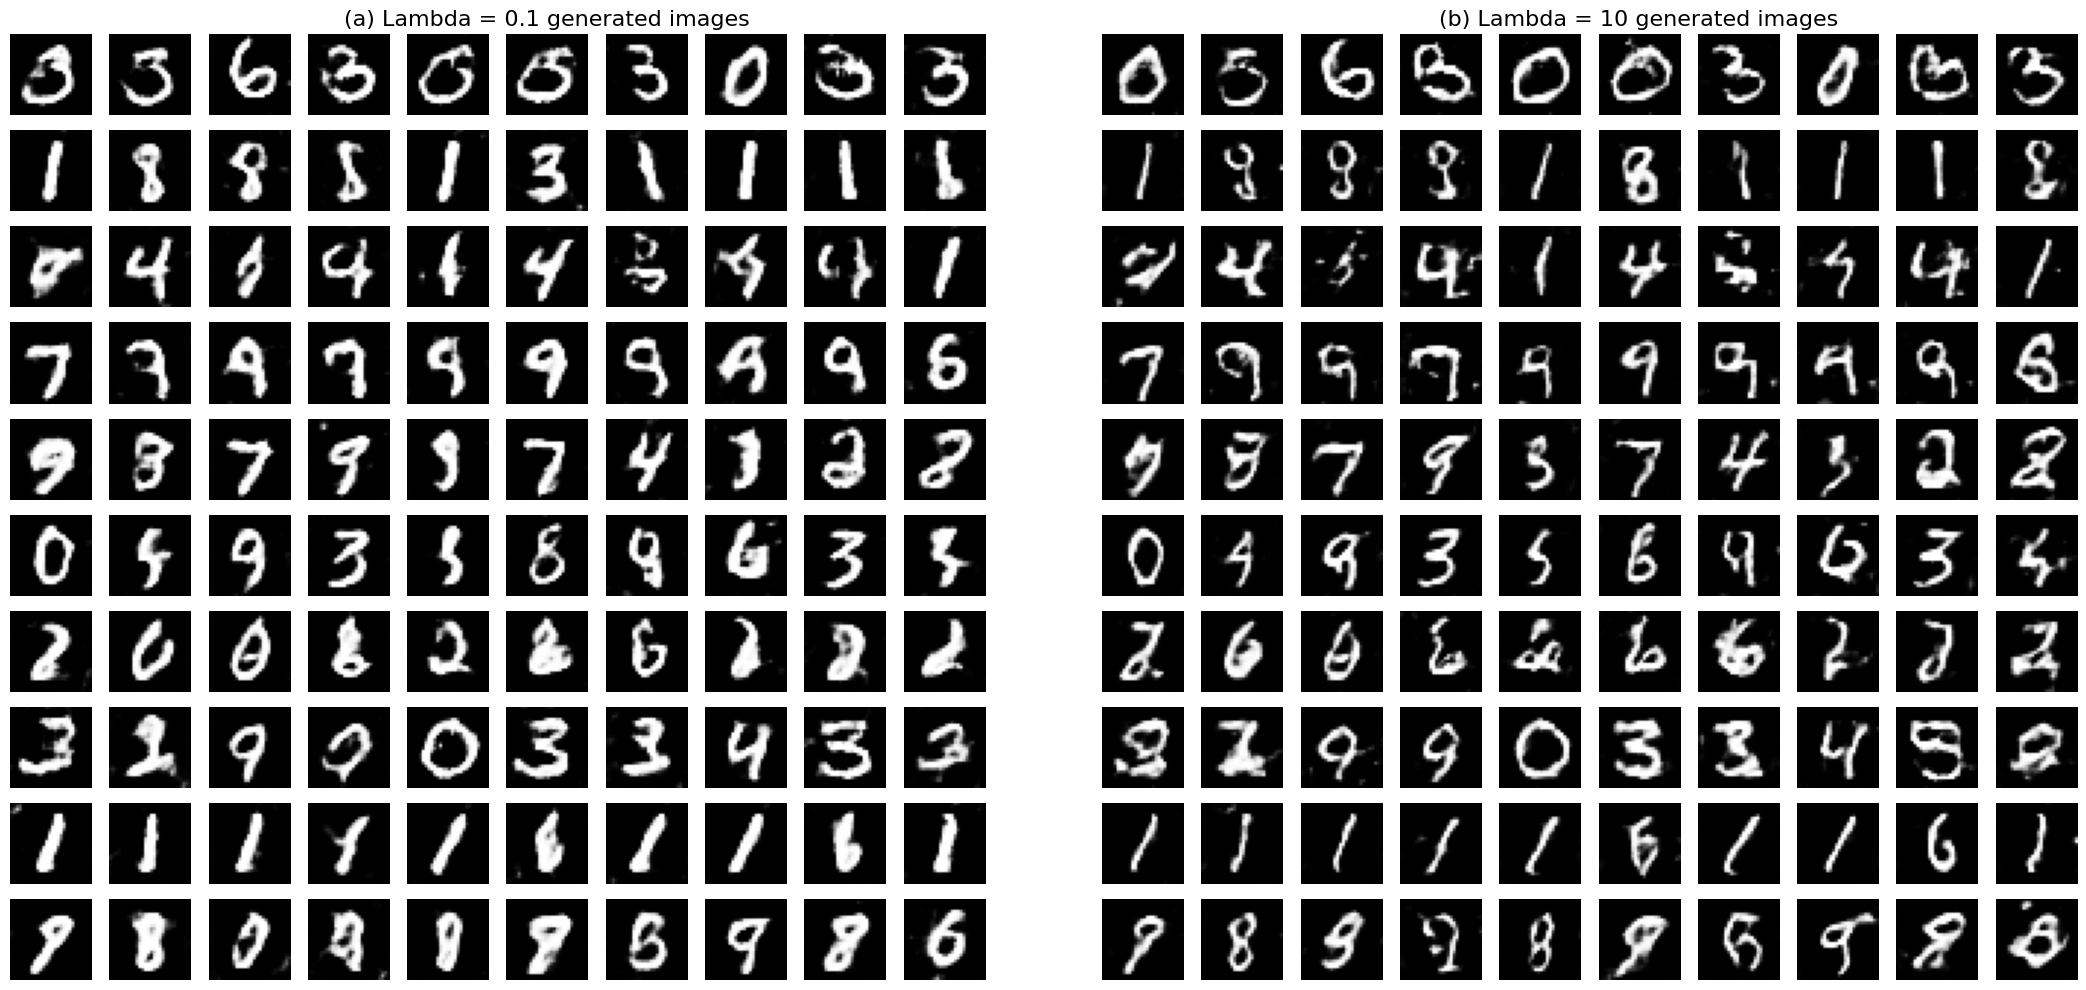

In [192]:
def train_model(generator, discriminator, combined, x_train, center_patches, lambda_val, epochs, batch_size):
    for epoch in range(epochs):
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        center_patches = center_patches[indices]
        # train discriminator 
        idx = np.random.randint(0, center_patches.shape[0], batch_size)
        imgs = x_train[idx]
        center_imgs = center_patches[idx]

        noise_and_patches = combine_noise_and_patches(center_imgs, noise_dim=100)
        gen_imgs = generator.predict(noise_and_patches)

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # train genarator
        g_loss = combined.train_on_batch(noise_and_patches, valid * lambda_val)
        
        # Extract central patch of generated image & calculate normalization loss
        fake_centers = np.array([extract_center_patch(img.reshape(28, 28, 1)) for img in gen_imgs])
        mse_loss = tf.keras.losses.MeanSquaredError()
        regularization_loss = mse_loss(center_imgs, fake_centers)

        # update g_loss
        g_loss += lambda_val * regularization_loss
        
        if epoch % 50 == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")

def generate_grid_images(generator, x_test, y_test, num_samples=10, noise_dim=100):
    grid_images = []
    for num in range(10): 
        num_indices = np.where(y_test == num)[0][:num_samples]
        num_images = x_test[num_indices]

        for img in num_images:
            center_patch = extract_center_patch(img).reshape(1, -1)
            noise = np.random.normal(0, 1, (1, noise_dim))
            noise_and_patch = np.concatenate((noise, center_patch), axis=1)
            generated_image = generator.predict(noise_and_patch)
            grid_images.append(generated_image[0, :, :])
    return grid_images          
            
            
# set λ value 
lambda_values = [0.1, 10]
all_generated_images = []

for lambda_val in lambda_values:
    print(f"Training with lambda = {lambda_val}")
    train_model(generator, discriminator, combined_model, x_train, center_patches_train, lambda_val, epochs=800, batch_size=64)

    # append generated images
    generated_images = generate_grid_images(generator, x_train, y_train, num_samples=10, noise_dim=100)
    all_generated_images.append(np.array(generated_images).reshape(10, 10, 28, 28))

# image visualization
num_images_per_row = 10
num_rows = 10

fig, axs = plt.subplots(10, 21, figsize=(21, 10)) 

for i in range(10): 
    for j in range(10):  
        axs[i, j].imshow(all_generated_images[0][i, j], cmap='gray')
        axs[i, j].axis('off')

    axs[i, 10].axis('off') 

    for j in range(11, 21):
        axs[i, j].imshow(all_generated_images[1][i, j-11], cmap='gray')
        axs[i, j].axis('off')

axs[0, 5].set_title('(a) Lambda = 0.1 generated images', fontsize=16)
axs[0, 16].set_title('(b) Lambda = 10 generated images', fontsize=16)

plt.tight_layout()
plt.show()